# Analysis of Home Value versus School Rating in New Jersey

## Data Cleaning
### Importing Dependencies and Source Files 

In [1]:
#import dependencies
from pathlib import Path
import numpy as np
import pandas as pd
import requests
import json
import matplotlib.pyplot as plt
import hvplot.pandas
from scipy.stats import linregress
import scipy.stats as stats
import seaborn as sns

In [2]:
#load and read home value csv
zillow_path = Path("Zip_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv")

#change zip code column to string 
zip = "RegionName"
zillow_df = pd.read_csv(zillow_path, dtype={zip:str})

#get a sample of the data
zillow_df.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,2000-01-31,...,2023-03-31,2023-04-30,2023-05-31,2023-06-30,2023-07-31,2023-08-31,2023-09-30,2023-10-31,2023-11-30,2023-12-31
0,91982,1,77494,zip,TX,TX,Katy,"Houston-The Woodlands-Sugar Land, TX",Fort Bend County,208752.177188,...,468400.012962,469600.790271,471587.869725,474687.471351,477460.027392,479919.299106,481726.908022,482958.479293,483644.390919,484254.484150
1,61148,2,08701,zip,NJ,NJ,Lakewood,"New York-Newark-Jersey City, NY-NJ-PA",Ocean County,133799.965954,...,517054.419786,521100.063176,526320.736228,532105.809020,538056.023382,543798.549494,549960.546654,557112.585902,563739.635747,568385.787815
2,91940,3,77449,zip,TX,TX,Katy,"Houston-The Woodlands-Sugar Land, TX",Harris County,102327.332899,...,274575.011824,273391.851083,272916.706411,273291.932508,274045.370378,274933.235990,275461.772882,275451.663963,275219.130604,274931.001539
3,62080,4,11368,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,147672.475058,...,480340.864596,473730.902787,466644.010241,461261.507623,459443.414913,459437.482269,458881.548977,456860.171677,453514.767036,449239.710048
4,91733,5,77084,zip,TX,TX,Houston,"Houston-The Woodlands-Sugar Land, TX",Harris County,100957.722364,...,267553.019024,266769.398609,266628.259422,267219.988459,268054.762069,268918.974834,269342.669492,269333.119699,268917.017812,268499.368493


In [3]:
#import School District Data 
great_path = Path("Schooldata.xlsx")
greatDf = pd.read_excel(great_path)
greatDf = greatDf[["Rating", "Zip Code", "Total Students Enrolled", "Students per teacher", "PercentLowIncome"]]
greatDf = greatDf.astype({"Zip Code":str}, errors="raise")
greatDf["Zip Code"] = [("0"+row) for row in greatDf["Zip Code"]]
greatDf.head()

,Rating,Zip Code,Total Students Enrolled,Students per teacher,PercentLowIncome
0,NaN,07504,77,4.0,0.45
1,6.0,07885,267,8.0,0.54
2,9.0,08105,108,14.0,0.60
3,6.0,07208,1000,16.0,0.73
4,2.0,08901,824,12.0,0.93


In [4]:
#create a new dataframe with only data from NJ
nj_df = zillow_df.loc[zillow_df["State"]=="NJ"]
nj_df.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,2000-01-31,...,2023-03-31,2023-04-30,2023-05-31,2023-06-30,2023-07-31,2023-08-31,2023-09-30,2023-10-31,2023-11-30,2023-12-31
1,61148,2,08701,zip,NJ,NJ,Lakewood,"New York-Newark-Jersey City, NY-NJ-PA",Ocean County,133799.965954,...,517054.419786,521100.063176,526320.736228,532105.809020,538056.023382,543798.549494,549960.546654,557112.585902,563739.635747,568385.787815
209,60565,215,07055,zip,NJ,NJ,Passaic,"New York-Newark-Jersey City, NY-NJ-PA",Passaic County,112257.216787,...,434515.584285,438302.873564,443556.388111,448065.465094,450674.818598,451572.325846,452642.300974,454584.729097,457385.725657,460060.463208
218,60642,224,07305,zip,NJ,NJ,Jersey City,"New York-Newark-Jersey City, NY-NJ-PA",Hudson County,155565.081912,...,452519.058390,453824.390647,456646.018622,459021.235458,462018.932069,464900.871530,467901.468729,470251.189218,472032.532734,473196.414613
263,60594,269,07087,zip,NJ,NJ,Union City,"New York-Newark-Jersey City, NY-NJ-PA",Hudson County,90766.359313,...,445259.657238,447288.497272,451733.111089,455802.885936,458105.447499,459328.697150,460471.564590,462596.991564,465896.827481,471667.587630
337,61169,344,08753,zip,NJ,NJ,Toms River,"New York-Newark-Jersey City, NY-NJ-PA",Ocean County,128491.913171,...,436283.234154,437756.598019,440522.020782,444103.558338,448297.681818,451976.275057,455271.357058,458529.076749,461728.978439,465068.322323


## Analysis of the Most Recent Data (2019-2021)

In [5]:
#Recent Data for Up to Date Analysis
#create a DataFrame with housing values from the 3 most recent years
nj_2020_df = nj_df[["RegionID","State", "City", "CountyName","RegionName", "2019-09-30","2020-09-30","2021-09-30"]]
nj_2020_df= nj_2020_df.astype({"RegionName":str},errors='raise')
#rename Region Name to Zip Code to match other DF
nj_2020_df=nj_2020_df.rename(columns={"RegionName":"Zip Code"})
len(nj_2020_df["Zip Code"].unique())


547

In [6]:
#join data sets on Zip Code Columns
mergeDf = pd.merge(nj_2020_df,greatDf,right_on="Zip Code",left_on="Zip Code", how="inner")
mergeDf.head()

,RegionID,State,City,CountyName,Zip Code,2019-09-30,2020-09-30,2021-09-30,Rating,Total Students Enrolled,Students per teacher,PercentLowIncome
0,61148,NJ,Lakewood,Ocean County,08701,322829.592985,333681.218345,402901.163953,7.0,451,11.0,0.91
1,61148,NJ,Lakewood,Ocean County,08701,322829.592985,333681.218345,402901.163953,7.0,425,9.0,0.96
2,61148,NJ,Lakewood,Ocean County,08701,322829.592985,333681.218345,402901.163953,NaN,215,6.0,0.60
3,61148,NJ,Lakewood,Ocean County,08701,322829.592985,333681.218345,402901.163953,2.0,1447,13.0,0.91
4,61148,NJ,Lakewood,Ocean County,08701,322829.592985,333681.218345,402901.163953,7.0,1284,15.0,0.95


In [7]:
#group schools by common Zip Code for analysis
groupDf = mergeDf.groupby("Zip Code")

In [8]:
#Recent Trend Analysis
#creating variable for metrics for each zipcode
rating = groupDf["Rating"].mean()
price19 = groupDf["2019-09-30"].mean()
price20 = groupDf["2020-09-30"].mean()
price21 = groupDf["2021-09-30"].mean()
lowinc = groupDf["PercentLowIncome"].mean()

In [9]:
#summary Data Frame
summaryDf = pd.DataFrame({
    "School Rating":rating,
    "2019 Avg. Home Value":price19,
    "2020 Avg. Home Value":price20,
    "2021 Avg. Home Value":price21,
    "Low Income %":lowinc
})
summaryDf

,School Rating,2019 Avg. Home Value,2020 Avg. Home Value,2021 Avg. Home Value,Low Income %
Zip Code,,,,,
07001,5.333333,308220.596206,327064.761332,372047.118278,0.436667
07002,4.615385,368670.676903,399717.335465,451018.434936,0.503077
07003,5.250000,350493.499990,392566.689858,445652.492475,0.427692
07004,4.000000,518138.226008,550259.058699,625586.249249,0.242500
07005,6.500000,458465.156935,470630.196332,528922.696782,0.228000
...,...,...,...,...,...
08887,9.000000,184833.122304,191375.036372,215171.488236,0.060000
08889,6.333333,462233.050678,468489.287716,530506.739532,0.090000
08901,2.250000,270962.882947,293378.030210,332437.232489,0.934615


In [10]:
# Binning Zip Codes by their average rating
bins = [0,5.9,7.9,10]
group_names = ["Below Average(<6)", "Good(6-8)", "Great(8+)"]
summaryDf["Rating"] = pd.cut(summaryDf["School Rating"], bins, labels=group_names,include_lowest=True)

#regrouped zip codes by common rating bin for analysis
groupedDf = summaryDf.groupby(["Rating"])

#Looking at the average house value for each school rating category
mean_vals = groupedDf["2021 Avg. Home Value"].mean()
mean_vals

Rating
Below Average(<6)    366913.118524
Good(6-8)            569330.989312
Great(8+)            805843.840547
Name: 2021 Avg. Home Value, dtype: float64

## Longitudinal Data Analysis (2000-2020)

In [11]:
#create a Data Frame with longitudinal data 2001-2020
longDf = nj_df[["RegionID","State", "City", "CountyName","RegionName", "2001-09-30","2005-09-30",\
                "2010-09-30","2015-09-30","2020-09-30"]]
longDf= longDf.astype({"RegionName":str},errors='raise')

#rename Region Name to Zip Code 
longDf=longDf.rename(columns={"RegionName":"Zip Code", "2001-09-30":"2000 Avg Home Price", "2010-09-30":"2010 Avg Home Price",\
                              "2020-09-30":"2020 Avg Home Price","2005-09-30": "2005 Avg Home Price", "2015-09-30":"2015 Avg Home Price"})
longDf.head()



,RegionID,State,City,CountyName,Zip Code,2000 Avg Home Price,2005 Avg Home Price,2010 Avg Home Price,2015 Avg Home Price,2020 Avg Home Price
1,61148,NJ,Lakewood,Ocean County,08701,159770.639641,299570.075168,228873.190981,280901.573985,333681.218345
209,60565,NJ,Passaic,Passaic County,07055,131904.445229,249145.066144,209026.374555,216725.022212,336101.327716
218,60642,NJ,Jersey City,Hudson County,07305,180976.945575,333026.132471,284654.081509,238668.782090,395956.883982
263,60594,NJ,Union City,Hudson County,07087,110653.118597,231930.708070,217246.969707,260121.628046,398658.069612
337,61169,NJ,Toms River,Ocean County,08753,152253.974989,296175.020872,259259.770840,253407.060914,304504.719520


In [12]:
#join data sets on Zip Code Columns
long_merge_df = pd.merge(longDf,greatDf,right_on="Zip Code",left_on="Zip Code", how="inner")

#group schools by common Zip Code for analysis
long_groupDf = long_merge_df.groupby("Zip Code")

#creating variable for metrics for each zipcode
rating = long_groupDf["Rating"].mean()
price2000 = long_groupDf["2000 Avg Home Price"].mean()
price2005 = long_groupDf["2005 Avg Home Price"].mean()
price2010 = long_groupDf["2010 Avg Home Price"].mean()
price2015 = long_groupDf["2015 Avg Home Price"].mean()
price2020 = long_groupDf["2020 Avg Home Price"].mean()

#summary Data Frame
long_summaryDf = pd.DataFrame({
    "School Rating":rating,
    "2000 Avg. Home Value":price2000,
    "2005 Avg. Home Value":price2005,
    "2010 Avg. Home Value":price2010,
    "2015 Avg. Home Value":price2015,
    "2020 Avg. Home Value":price2020,
})
long_summaryDf

,School Rating,2000 Avg. Home Value,2005 Avg. Home Value,2010 Avg. Home Value,2015 Avg. Home Value,2020 Avg. Home Value
Zip Code,,,,,,
07001,5.333333,181146.177252,313736.842759,266637.895525,258487.793632,327064.761332
07002,4.615385,176676.341426,339061.201362,267168.718425,267914.560772,399717.335465
07003,5.250000,181682.473121,322912.250354,280666.943065,288640.955664,392566.689858
07004,4.000000,326326.353939,524190.411476,488802.693883,463331.921509,550259.058699
07005,6.500000,286613.357293,458695.614017,413541.087865,425301.705352,470630.196332
...,...,...,...,...,...,...
08887,9.000000,134287.560427,218841.266246,179515.454546,161921.334059,191375.036372
08889,6.333333,335461.714599,494882.440952,437470.508806,439851.639582,468489.287716
08901,2.250000,152538.261206,294449.324329,240311.384287,218851.641141,293378.030210


In [13]:
#binning Zip Codes by their average rating
bins = [0,5.9,7.9,10]
group_names = ["Below Average(<6)", "Good(6-8)", "Great(8+)"]
long_summaryDf["Rating"] = pd.cut(long_summaryDf["School Rating"], bins, labels=group_names,include_lowest=True)

#regrouped zip codes by common rating bin for analysis
long_groupedDf = long_summaryDf.groupby(["Rating"])

#variables created for the average house value for each year for each category
long_mean_val_2000 = long_groupedDf["2000 Avg. Home Value"].mean()
long_mean_val_2005 = long_groupedDf["2005 Avg. Home Value"].mean()
long_mean_val_2010 = long_groupedDf["2010 Avg. Home Value"].mean()
long_mean_val_2015 = long_groupedDf["2015 Avg. Home Value"].mean()
long_mean_val_2020 = long_groupedDf["2020 Avg. Home Value"].mean()

#create lists for the longitudinal data by category
below_avg = [long_mean_val_2000[0],long_mean_val_2005[0], long_mean_val_2010[0],long_mean_val_2015[0], long_mean_val_2020[0]]
good = [long_mean_val_2000[1],long_mean_val_2005[1], long_mean_val_2010[1],long_mean_val_2015[1], long_mean_val_2020[1]]
great =[long_mean_val_2000[2],long_mean_val_2005[2], long_mean_val_2010[2],long_mean_val_2015[2], long_mean_val_2020[2]]


#summary longitudinal dataframe
long_school_df = pd.DataFrame(
{"Year":[2000,2005,2010,2015,2020],
 "Below Average(<6)":below_avg,
 "Good (6-8)":good,
 "Great (8+)":great
})
long_school_df

,Year,Below Average(<6),Good (6-8),Great (8+)
0,2000,170901.073659,275158.294831,374368.714962
1,2005,294299.653812,455779.299865,615674.988809
2,2010,256265.083082,409334.630621,567400.721279
3,2015,251195.659058,436094.255219,638232.955398
4,2020,313661.546049,492903.587389,688541.219643


In [14]:
#average value per year
avg2000 = long_merge_df["2000 Avg Home Price"].mean()
avg2005 = long_merge_df["2005 Avg Home Price"].mean()
avg2010 = long_merge_df["2010 Avg Home Price"].mean()
avg2015 = long_merge_df["2015 Avg Home Price"].mean()
avg2020 = long_merge_df["2020 Avg Home Price"].mean()

avgs = [avg2000, avg2005, avg2010, avg2015, avg2020]


vs_avg_df = pd.DataFrame(
{"Year":[2000,2005,2010,2015,2020],
 "Average House Value":avgs,
 "Below Average(<6)":below_avg,
 "Good (6-8)":good,
 "Great (8+)":great
})

#Comparing the Home Value of that Category to the Average
vs_avg_df["Value of a Below Average School"] = vs_avg_df["Below Average(<6)"] - vs_avg_df["Average House Value"]
vs_avg_df["Value of Good School"] = vs_avg_df["Good (6-8)"] - vs_avg_df["Average House Value"]
vs_avg_df["Value of a Great School"] = vs_avg_df["Great (8+)"] - vs_avg_df["Average House Value"]
vs_avg_df

,Year,Average House Value,Below Average(<6),Good (6-8),Great (8+),Value of a Below Average School,Value of Good School,Value of a Great School
0,2000,208506.730504,170901.073659,275158.294831,374368.714962,-37605.656844,66651.564327,165861.984458
1,2005,352093.130796,294299.653812,455779.299865,615674.988809,-57793.476984,103686.169069,263581.858013
2,2010,310840.002247,256265.083082,409334.630621,567400.721279,-54574.919165,98494.628373,256560.719032
3,2015,318051.275528,251195.659058,436094.255219,638232.955398,-66855.616470,118042.979691,320181.679870
4,2020,383159.581507,313661.546049,492903.587389,688541.219643,-69498.035457,109744.005882,305381.638136


## Graphs and Statistical Testing

### Longitudinal Analysis

F_onewayResult(statistic=15.532137309073562, pvalue=0.00046814960207927056)


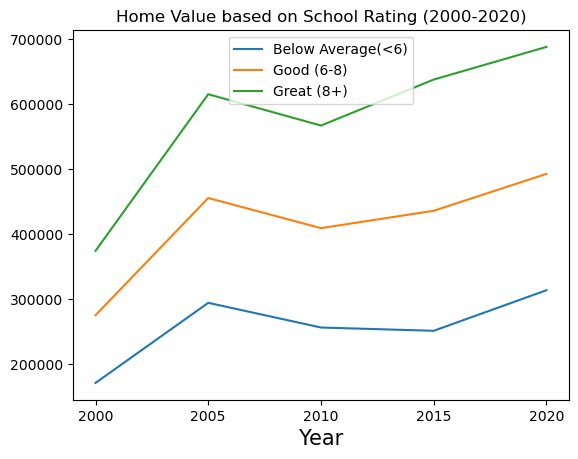

In [79]:
vs_avg_df.plot(kind="line",x="Year",y="Below Average(<6)")
vs_avg_df.plot(kind="line",x="Year",y="Good (6-8)",ax=plt.gca())
vs_avg_df.plot(kind="line",x="Year",y="Great (8+)",ax=plt.gca())
plt.xticks(ticks=[2000,2005,2010,2015,2020],labels=[2000,2005,2010,2015,2020] )
plt.title("Home Value based on School Rating (2000-2020)")
plt.figsize=(10,6)
plt.savefig("Outputs/Change_in_home_price.png")
rating_anova = stats.f_oneway(below_avg,good,great)
print(rating_anova)
plt.show()

F_onewayResult(statistic=91.62032854270838, pvalue=5.3909575566700675e-08)


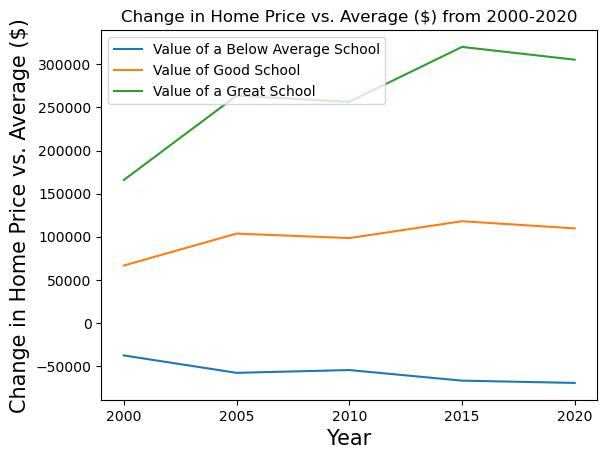

In [65]:
vs_avg_df.plot(kind="line", x="Year", y="Value of a Below Average School")
vs_avg_df.plot(kind="line", x="Year", y="Value of Good School", ax=plt.gca())
vs_avg_df.plot(kind="line", x="Year", y="Value of a Great School", ax=plt.gca())
plt.ylabel("Change in Home Price vs. Average ($)")
plt.title("Change in Home Price vs. Average ($) from 2000-2020")
plt.xticks(ticks=[2000,2005,2010,2015,2020],labels=[2000,2005,2010,2015,2020] )

plt.savefig("Outputs/Change_in_home_price_vs_avg.png", bbox_inches='tight')
vs_avg_anova = stats.f_oneway(vs_avg_df["Value of a Below Average School"],vs_avg_df["Value of Good School"],vs_avg_df["Value of a Great School"])
print(vs_avg_anova)
plt.show()

## Recent Data Analysis (2019-2021)
### School Rating Category vs Home Value

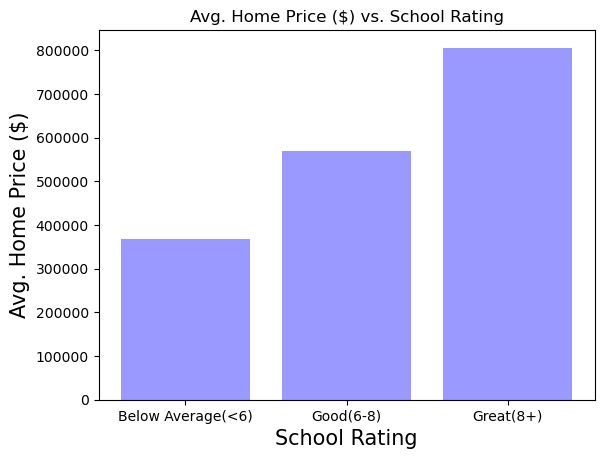

In [78]:
#bar graph illustrating the average home price for each bin
bar2021 = plt.bar(group_names, mean_vals, color="b",alpha=.4, align="center")
plt.xlabel("School Rating")
plt.ylabel("Avg. Home Price ($)")
plt.title("Avg. Home Price ($) vs. School Rating")
plt.savefig("Outputs/bar_rating_vs_value.png", bbox_inches='tight')
plt.show()

In [20]:
sorted_by_price = summaryDf.sort_values(by="2021 Avg. Home Value", ascending=False)
sorted_by_price

,School Rating,2019 Avg. Home Value,2020 Avg. Home Value,2021 Avg. Home Value,Rating
Zip Code,,,,,
07723,6.000000,1.870399e+06,2.014282e+06,2.675285e+06,Good(6-8)
07620,9.000000,2.172472e+06,2.078202e+06,2.427716e+06,Great(8+)
08202,10.000000,1.448033e+06,1.586109e+06,2.144990e+06,Great(8+)
08247,10.000000,1.306273e+06,1.427352e+06,1.970783e+06,Great(8+)
07976,7.000000,1.421632e+06,1.406838e+06,1.656800e+06,Good(6-8)
...,...,...,...,...,...
08609,1.750000,6.900878e+04,8.056694e+04,1.143999e+05,Below Average(<6)
08611,2.666667,7.026801e+04,7.963207e+04,1.074686e+05,Below Average(<6)
08102,3.000000,6.907392e+04,8.178659e+04,9.365778e+04,Below Average(<6)


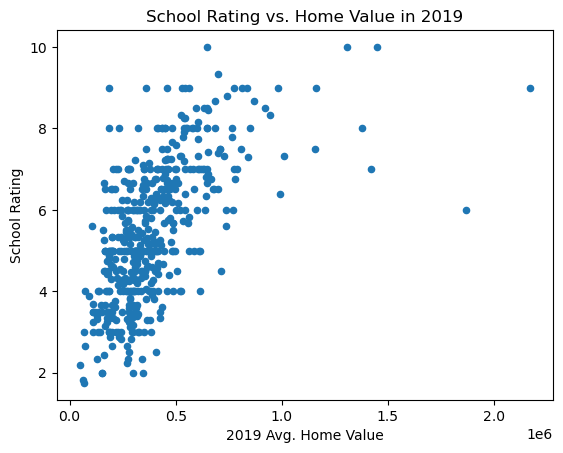

In [21]:
plot = summaryDf.plot(kind="scatter", x="2019 Avg. Home Value", y="School Rating")

plt.title("School Rating vs. Home Value in 2019")

plt.show()

The r-value is: 0.36500345265789574
y = 4.508827629709254e-06x + 3.7


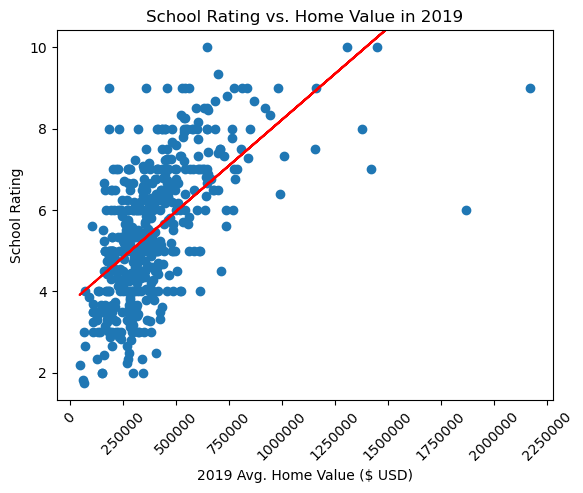

In [26]:
# 2019 has some missing values - drop those for continuity
missing_2019_df = summaryDf.dropna(subset=['2019 Avg. Home Value', 'School Rating'])

# Define x and y values
x_values = missing_2019_df['2019 Avg. Home Value']
y_values = missing_2019_df['School Rating']

# Define a function to create Linear Regression plots
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept

# Find y = mx + b
line_eq = "y = " + str(slope) + "x + " + str(round(intercept, 2))

# Create plot
plt.scatter(x_values, y_values)
plt.plot(x_values, regress_values, "r-")

plt.title("School Rating vs. Home Value in 2019")
plt.xlabel("2019 Avg. Home Value ($ USD)")
plt.ylabel("School Rating")
plt.ticklabel_format(style='plain')

x_buffer = (max(x_values) - min(x_values)) * 0.05
plt.xlim(min(x_values) - x_buffer, max(x_values) + x_buffer)

plt.xticks([0, 250000, 500000, 750000, 1000000, 1250000, 1500000, 1750000, 2000000, 2250000], rotation=45)

y_buffer = (max(y_values) - min(y_values)) * 0.05
plt.ylim(min(y_values) - y_buffer, max(y_values) + y_buffer)

print(f"The r-value is: {rvalue**2}")
print(line_eq)
plt.figsize=(10,6)
plt.savefig("Outputs/school_rating_vs_2019_value.png", bbox_inches='tight')
plt.show()

## 2020 School Rating and Home Values

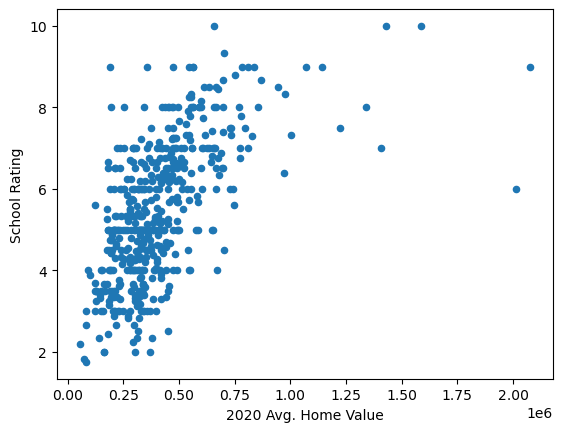

In [23]:
plot2020 = summaryDf.plot(kind="scatter", x="2020 Avg. Home Value", y="School Rating")

The r-value is: 0.3541657935463522
y = 4.438375282196353e-06x + 3.65


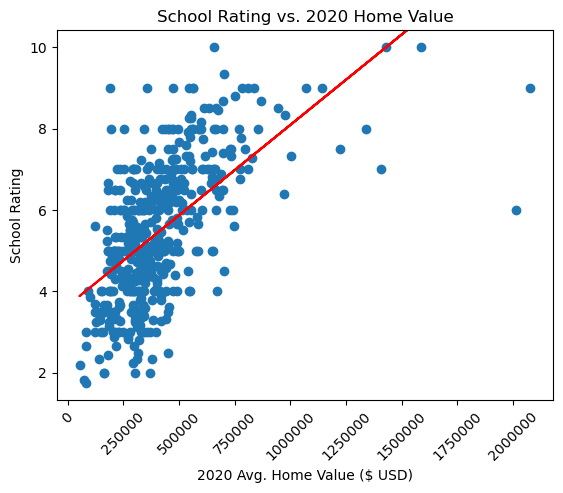

In [27]:
# 2020 has some missing values - drop those for continuity
missing_2020_df = summaryDf.dropna(subset=['2020 Avg. Home Value', 'School Rating'])

# Define x and y values
x_values = missing_2020_df['2020 Avg. Home Value']
y_values = missing_2020_df['School Rating']

# Define a function to create Linear Regression plots
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept

# Find y = mx + b
line_eq = "y = " + str(slope) + "x + " + str(round(intercept, 2)) 

# Create plot
plt.scatter(x_values, y_values)
plt.plot(x_values, regress_values, "r-")

plt.title("School Rating vs. 2020 Home Value")
plt.xlabel("2020 Avg. Home Value ($ USD)")
plt.ylabel("School Rating")
plt.ticklabel_format(style='plain') 

x_buffer = (max(x_values) - min(x_values)) * 0.05
plt.xlim(min(x_values) - x_buffer, max(x_values) + x_buffer)

plt.xticks(rotation=45)

y_buffer = (max(y_values) - min(y_values)) * 0.05
plt.ylim(min(y_values) - y_buffer, max(y_values) + y_buffer)
plt.xticks(rotation=45)

print(f"The r-value is: {rvalue**2}")
print(line_eq)
plt.figsize=(10,6)
plt.savefig("Outputs/school_rating_vs_2020_home_value.png", bbox_inches='tight')
plt.show()

## 2021 School Rating and Home Values

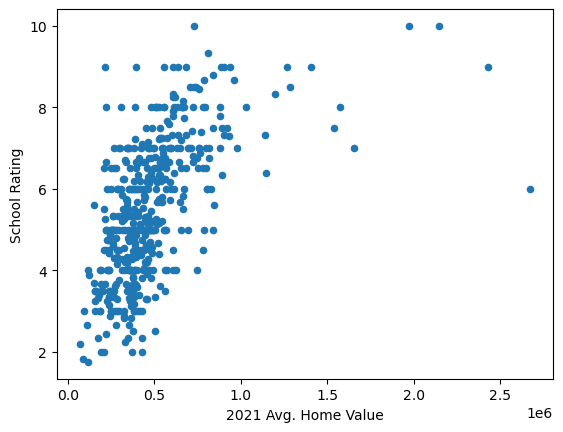

In [25]:
plot2021 = summaryDf.plot(kind="scatter", x="2021 Avg. Home Value", y="School Rating")

The r-value is: 0.3274298021412642
y = 3.5293218559848177e-06x + 3.79


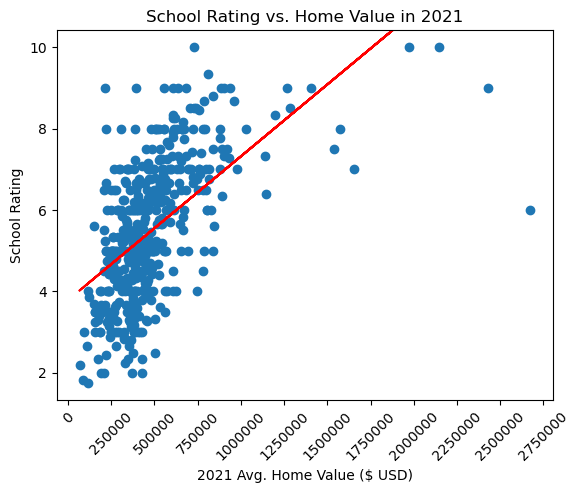

In [30]:
# 2021 has some missing values - drop those for continuity
missing_2021_df = summaryDf.dropna(subset=['2020 Avg. Home Value', 'School Rating'])

# Define x and y values
x_values = missing_2021_df['2021 Avg. Home Value']
y_values = missing_2021_df['School Rating']

# Define a function to create Linear Regression plots
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept

# Find y = mx + b
line_eq = "y = " + str(slope) + "x + " + str(round(intercept, 2)) 

# Create plot
plt.scatter(x_values, y_values)
plt.plot(x_values, regress_values, "r-")

plt.title("School Rating vs. Home Value in 2021")
plt.xlabel("2021 Avg. Home Value ($ USD)")
plt.ylabel("School Rating")
plt.ticklabel_format(style='plain') 

x_buffer = (max(x_values) - min(x_values)) * 0.05
plt.xlim(min(x_values) - x_buffer, max(x_values) + x_buffer)

plt.xticks([0, 250000, 500000, 750000, 1000000, 1250000, 1500000, 1750000, 2000000, 2250000, 2500000, 2750000], rotation=45)

y_buffer = (max(y_values) - min(y_values)) * 0.05
plt.ylim(min(y_values) - y_buffer, max(y_values) + y_buffer)

print(f"The r-value is: {rvalue**2}")
print(line_eq)
plt.figsize=(10,6)
plt.savefig("Outputs/school_rating_vs_2021_home_value.png", bbox_inches='tight')
plt.show()

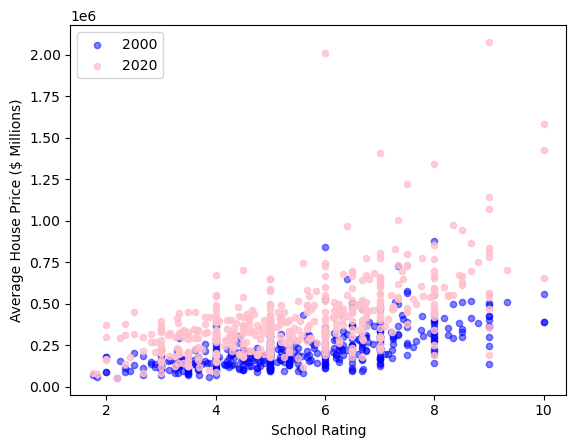

In [29]:
long_summaryDf.plot(kind="scatter", x="School Rating", y="2000 Avg. Home Value",alpha=.5, color="blue", label="2000")
#long_summaryDf.plot(kind="scatter", x="School Rating", y="2010 Avg. Home Value",color="red",alpha=.5, label="2010",ax=plt.gca())
long_summaryDf.plot(kind="scatter", x="School Rating", y="2020 Avg. Home Value",color="pink",label="2020",alpha=.8, ax=plt.gca())
plt.ylabel("Average House Price ($ Millions)")
plt.show()

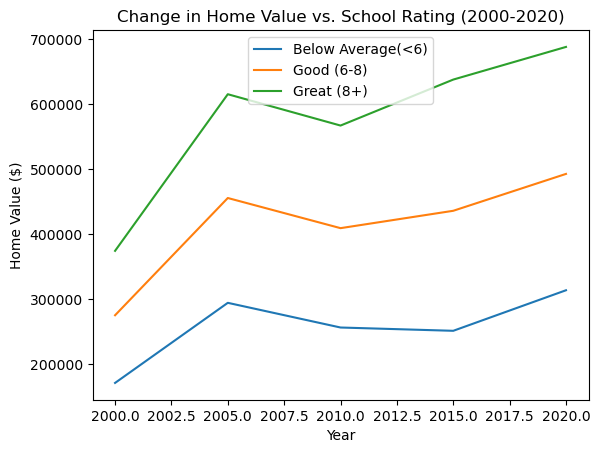

In [30]:
long_school_df.plot(kind="line", x="Year")
plt.ylabel("Home Value ($)")
plt.title("Change in Home Value vs. School Rating (2000-2020)")
plt.show()

### Low Income Student Graphs

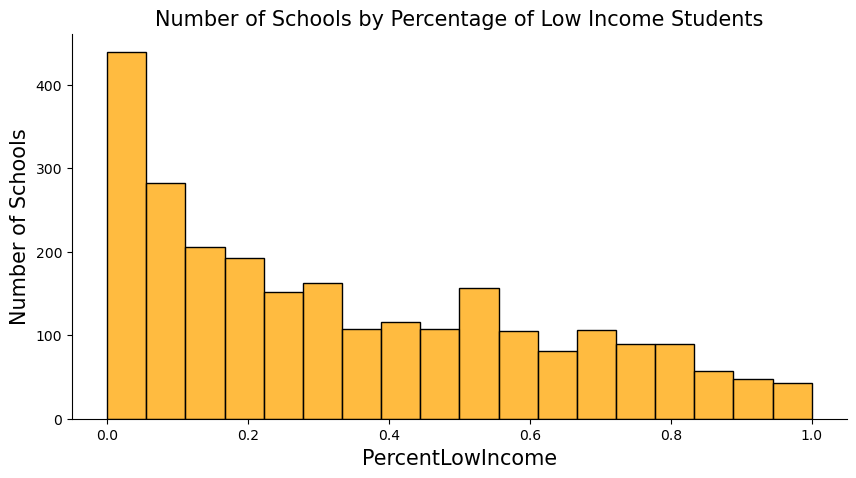

In [67]:
plt.figure(figsize=(10,5))
sns.set_context(rc={'axes.labelsize':15})
ax = sns.histplot(greatDf['PercentLowIncome'], bins = 18, color = 'orange')
sns.despine()
ax.set_title('Number of Schools by Percentage of Low Income Students', fontdict = {'fontsize': 15})
ax.set_xlabel('PercentLowIncome')
ax.set_ylabel('Number of Schools')
plt.savefig("Outputs/low_income.png", bbox_inches='tight')
plt.show()

The r-value is: 0.4825212800787183
y = -5.1778181815893065x + 6.9


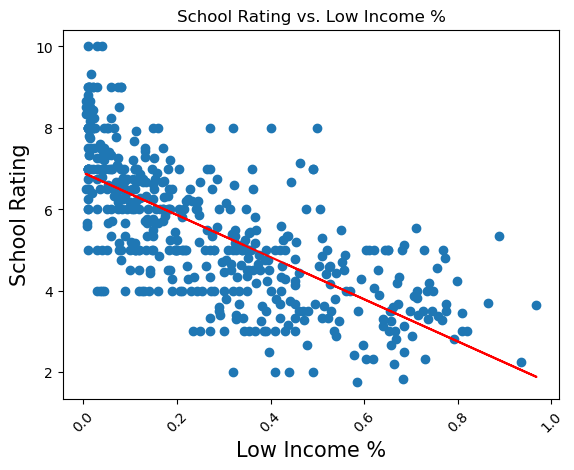

In [80]:
# 2021 has some missing values - drop those for continuity
missing_2021_df = summaryDf.dropna(subset=['2020 Avg. Home Value', 'School Rating'])

# Define x and y values
x_values = missing_2021_df['Low Income %']
y_values = missing_2021_df['School Rating']

# Define a function to create Linear Regression plots
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept

# Find y = mx + b
line_eq = "y = " + str(slope) + "x + " + str(round(intercept, 2)) 

# Create plot
plt.scatter(x_values, y_values)
plt.plot(x_values, regress_values, "r-")

plt.title("School Rating vs. Low Income %")
plt.xlabel("Low Income %")
plt.ylabel("School Rating")
plt.ticklabel_format(style='plain') 
plt.xticks(rotation=45)

print(f"The r-value is: {rvalue**2}")
print(line_eq)
plt.figsize=(10,6)
plt.savefig("Outputs/school_rating_vs_Low_income.png", bbox_inches='tight')
plt.show()

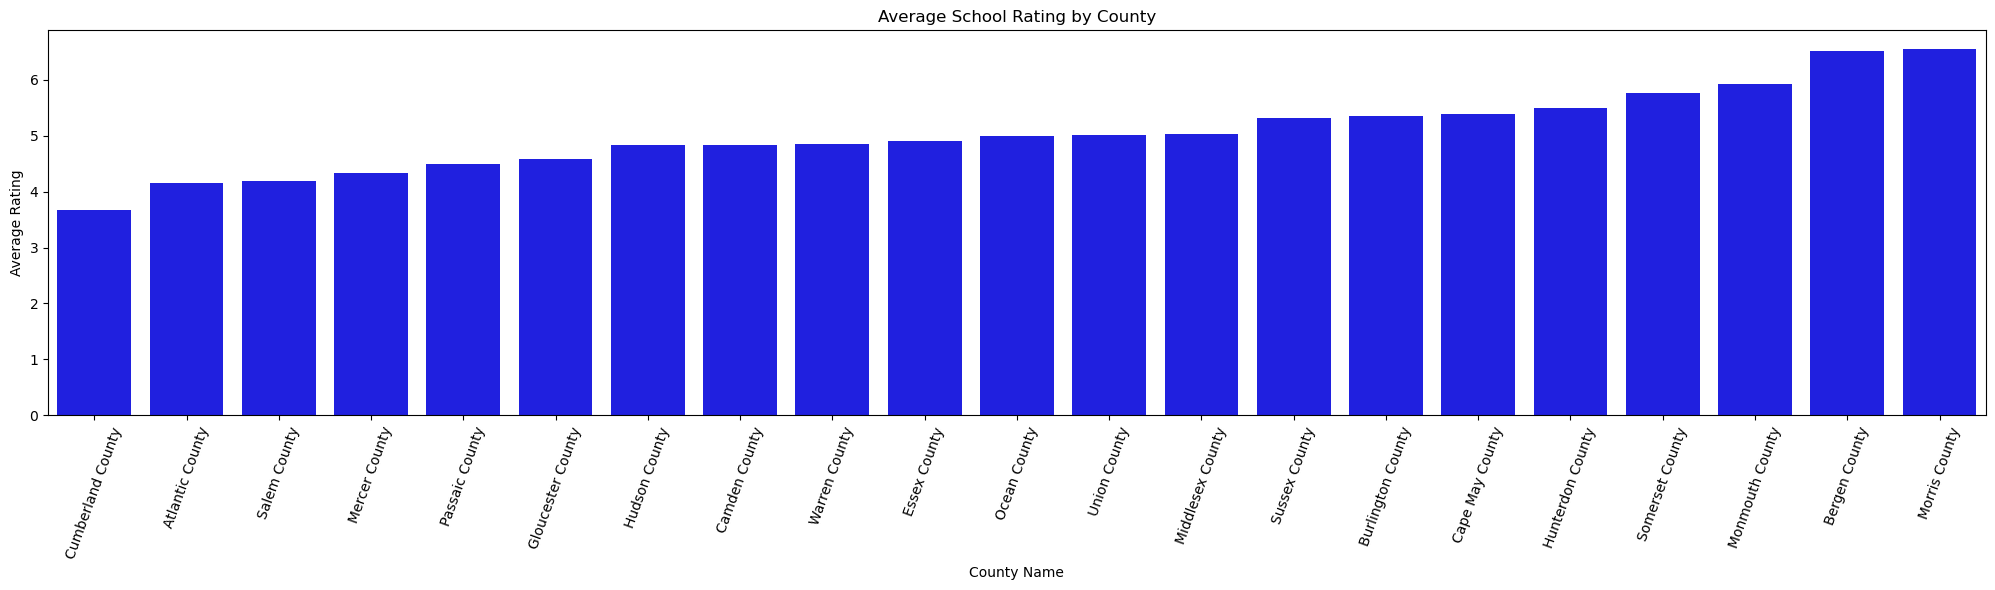

In [31]:
# Grouping by the county and average school ranking
import seaborn as sns
school_rating_by_county = mergeDf.groupby('CountyName')['Rating'] .mean().reset_index().sort_values('Rating')


# Plotting this distribution
plt.figure(figsize=(25,5))
sns.barplot(data=school_rating_by_county, x='CountyName', y='Rating', color='blue')
plt.title('Average School Rating by County')
plt.xlabel('County Name')
plt.xticks(rotation=70)
plt.ylabel('Average Rating')
plt.show()

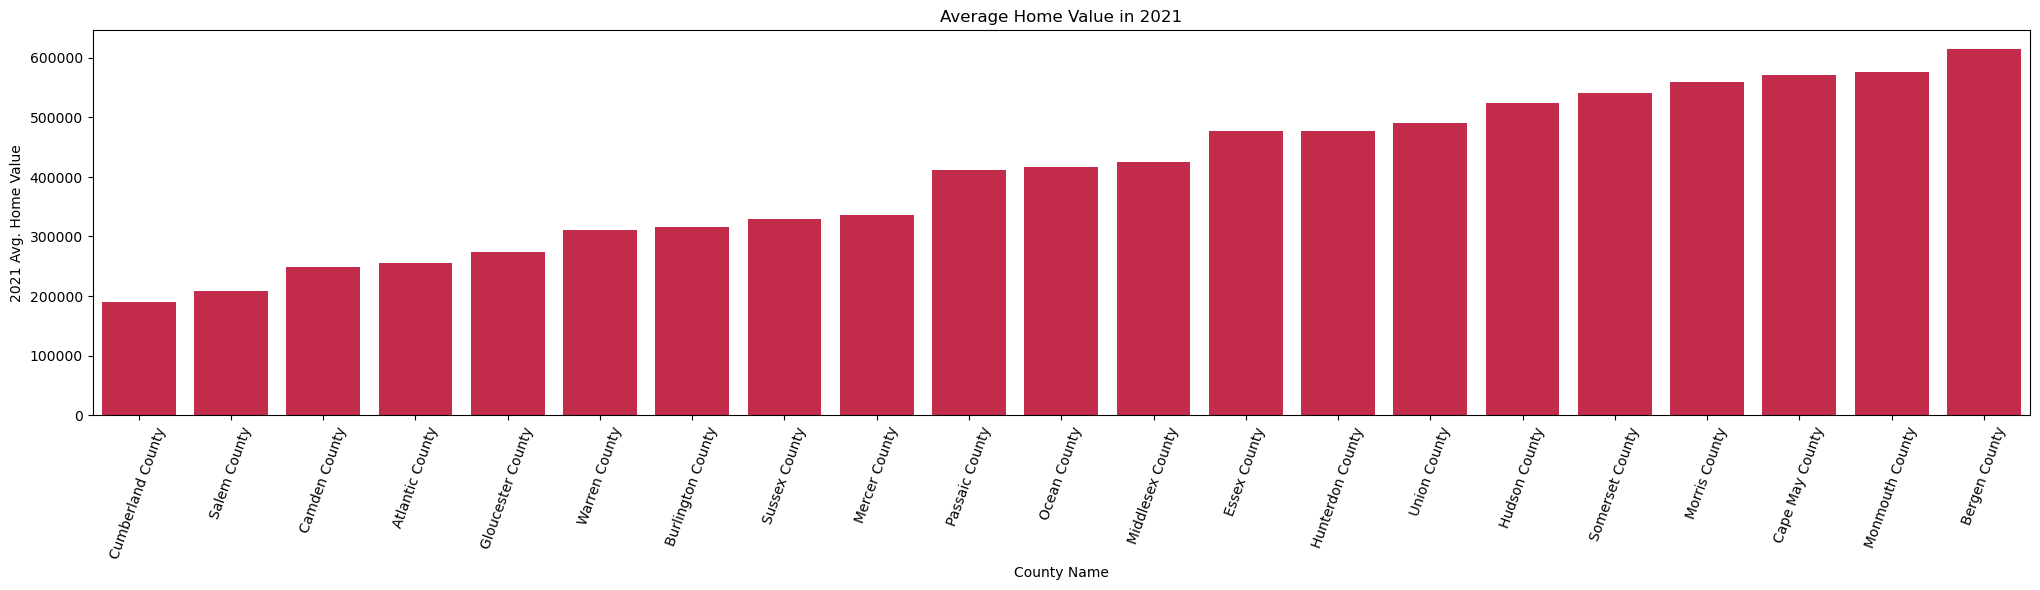

In [32]:
# Grouping by the county and average Home Value
avg_ranking_by_county = mergeDf.groupby('CountyName')['2021-09-30'].mean().reset_index().sort_values('2021-09-30')
# Plotting this distribution
plt.figure(figsize=(25,5))
sns.barplot(data=avg_ranking_by_county, x='CountyName', y='2021-09-30', color='crimson')
plt.title('Average Home Value in 2021')
plt.xlabel('County Name')
plt.xticks(rotation=70)
plt.ylabel('2021 Avg. Home Value')
plt.show()

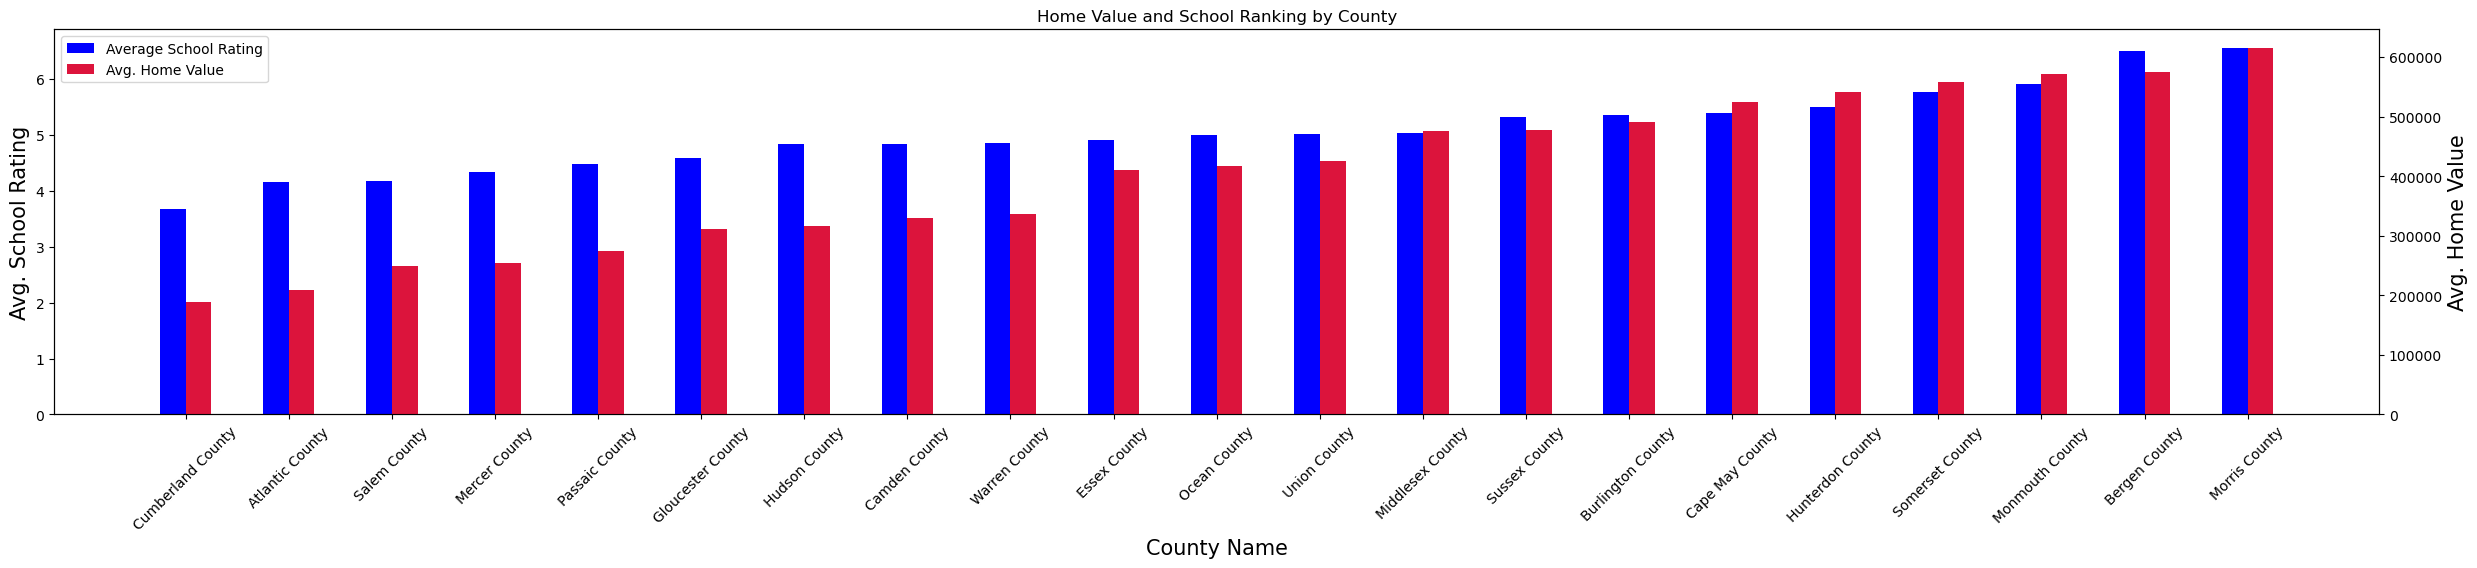

In [68]:
fig, ax1 = plt.subplots(figsize=(30,5))

x = np.arange(len(school_rating_by_county))
bar_width = 0.25

ax1.bar(x - bar_width/2, school_rating_by_county['Rating'], color='blue', width=bar_width, label='Average School Rating')
ax1.set_xlabel('County Name')
ax1.set_ylabel('Avg. School Rating')
ax1.tick_params(axis='y')

ax2 = ax1.twinx()
ax2.bar(x + bar_width/2, avg_ranking_by_county['2021-09-30'], color='crimson', width=bar_width, label='Avg. Home Value')
ax2.set_ylabel('Avg. Home Value')
ax2.tick_params(axis='y')

ax1.set_xticks(x)
ax1.set_xticklabels(school_rating_by_county['CountyName'], rotation=45)

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.title('Home Value and School Ranking by County')
plt.figsize=(10,6)
plt.savefig("Outputs/Home_Value_and_Ranking_by_county.png", bbox_inches='tight')
plt.show()